<a href="https://colab.research.google.com/github/megan-the-astronomer/ASTR229/blob/main/dealing_with_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic data processing

In this notebook, we'll walk through basic data reduction. Before we can begin analyzing our data, there are several steps that we need to do to remove signal from the detector. We discuss each of the key corrections - bias, dark, and flat fielding - below. Aligning dithered images and combining into a three-color image are handled in separate notebooks.

For more information about the nitty gritty details of CCD processing and operation, you may enjoy the classic paper from [Massey & Jacoby (1992)](http://www2.lowell.edu/users/massey/Massey_Jacoby.pdf).

In [ ]:
# start by importing the necessities
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bias frames

A bias image is an image taken with zero exposure time. Counts in a bias frame are never zero even though this image is taken with no light hitting the CCD and no integration time. CCDs add a voltage offset to all pixels so that when the accumulated signal in each pixel is converted to a number, the number is always positive. Ideally this number would be constant pixel-to-pixel and night-to-night. In practice, there are slight variations between pixels and over time.

Let's take a look at some bias frame taken with the PFC on the McDonald 30".

To make it easier to read in multiple files, let's use the ```glob``` package.

In [ ]:
import glob

```glob``` allows you to specify paths in the same way you would on the command line in a unix terminal. This allows you to use wildcard characters to do a general search. The ```?``` allows a single character to be equal to any value while ```*``` replaces a string of any length.

Use this to read the filenames of all the bias frames in the folder.

In [ ]:
biases = glob.glob('/content/drive/MyDrive/my_ASTR229_data/biases/*.fits')
biases

['/content/drive/MyDrive/my_ASTR229_data/biases/obj0078.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0076.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0075.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0077.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0079.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0074.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0083.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0082.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0081.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0080.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0084.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0008.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0002.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0009.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0003.fits',
 '/content/drive/MyDrive/my_ASTR229_data/biases/obj0001

Look at the header information for one of the files. Notice that the exposure time 'EXPTIME' is 0.0 and the 'IMGTYPE' is 'zero.'

In [ ]:
fits.getheader(biases[0])

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1056 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
DATE    = '2024-02-15T06:27:22' / Date FITS file was generated                  
IRAF-TLM= '2024-02-15T06:26:29' / Time of last modification                     
OBJECT  = 'Bias    '           / Name of the object observed                    
OBSERVAT= 'MCDONALD         

Take a look at one of the bias images to see what it looks like.

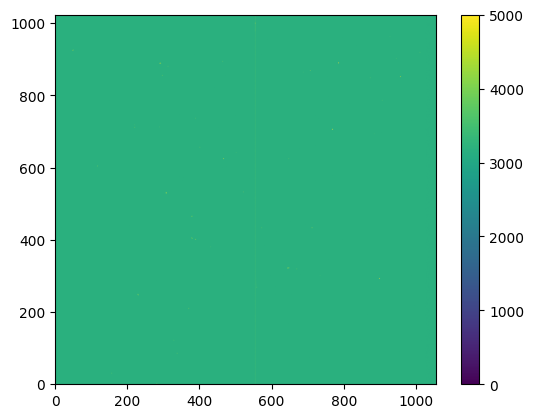

In [ ]:
bias1 = fits.getdata(biases[0])
plt.imshow(bias1, origin='lower', vmin=0, vmax=5000)
plt.colorbar()

The image looks pretty uniform but the average value is definitely not zero. Let's take a look at the median and standard deviation to get a better idea of what is in the image.

In [ ]:
med_bias1 = np.median(bias1)
med_bias1

np.float64(3174.0)

In [ ]:
std_bias1 = np.std(bias1)
std_bias1

np.float64(22.857683425974198)

Use the median and the standard deviation to set the minimum and maximum values for the color scaling on the image.

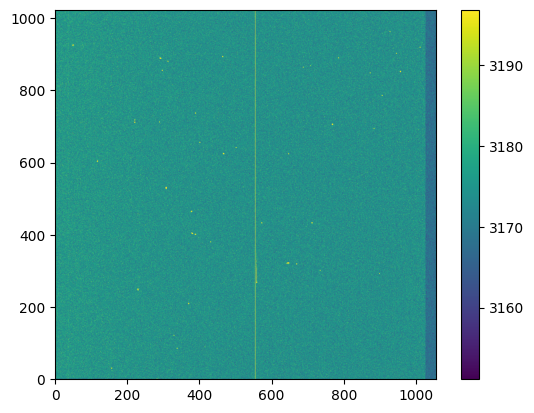

In [ ]:
plt.imshow(bias1, origin='lower', vmin=(med_bias1-std_bias1), vmax=(med_bias1+std_bias1))
plt.colorbar()

With this tighter scaling, we can start to see some of the detector artifacts. If you look at a different bias image, does it look the same? What do you think the bright column in the middle of the image is? the dark column on the right of the image?

We always take multiple bias frames (multiple frames of all types, bias, flat, science, ...) to manage the noise in the image. Let's see why. Read in all the bias frames and combine them into a master bias frame.

In [ ]:
bias_timestream = [fits.getdata(x) for x in biases]

The formatting of the loop here is a little different from what we've seen so far but the type of output is familiar.  

In [ ]:
type(bias_timestream)

list

Noise is random which means that it will be positive roughly as often as it will be negative. By combining multiple frames, we hope that the noise averages out, leaving us with a more accurate measure of the bias.

In [ ]:
# average of the bias frames
mean_bias = np.mean(bias_timestream, axis=0)
# median
median_bias = np.median(bias_timestream, axis=0)

Which should you use - the mean or the median?

Display both the mean and the median bias frames. How do they compare?

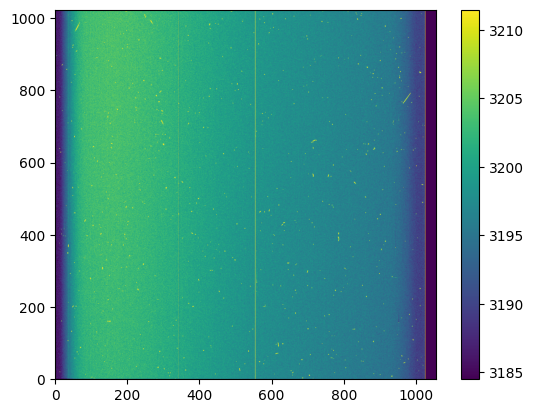

In [ ]:
# mean-combined
plt.imshow(mean_bias, origin='lower', vmin=(mean_bias.mean()-mean_bias.std()), vmax=(mean_bias.mean()+mean_bias.std()))
plt.colorbar()

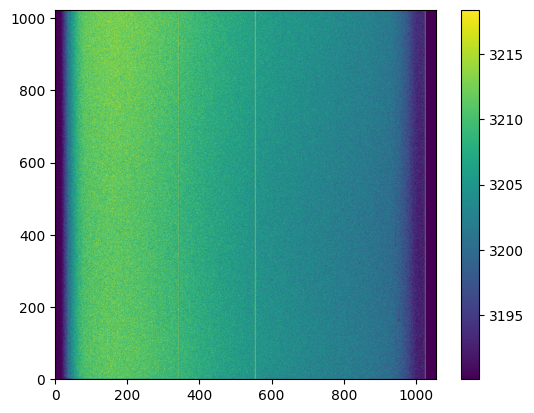

In [ ]:
# median-combined
plt.imshow(median_bias, origin='lower', vmin=(median_bias.mean()-median_bias.std()), vmax=(median_bias.mean()+median_bias.std()))
plt.colorbar()

The mean is affected by outliers whereas the median is not. Notice how many bright pixels you can see in the mean image (what are these?). So we'll use the median.

# measuring the bias with a bias strip

The Prime Focus Camera (PFC) at McDonald has a bias strip on the side. The purpose of this strip is to measure the pedestal (bias) value that can be subtracted from each row.

Why use a bias strip instead of a separate bias frame? In the bad old days, the bias in the detector could drift over the course of the night. Having a bias strip alongside the science data gives a real-time measure of the bias for every frame. Like everything, this is a tradeoff - what information do you lose?

To see the bias strip in the McDonald images, start by reading in one of the science images.

In [ ]:
my_file = fits.open('/content/drive/MyDrive/my_ASTR229_data/m82/obj0063.fits')

In [ ]:
data = my_file[0].data
header = my_file[0].header

It's been a while since we looked at some data. Recall that there are several ways you can examine the data to get a quick idea of its properties - printing, plotting, etc.

Another thing you may find useful is to check the shape of your data using the ```shape``` function.

In [ ]:
data.shape

(1024, 1056)

First, we have to figure out where the bias strip is. Notice that ds9 does not display the bias strip when you open an image, so you'll want to do this step in python. Notice the strip on the right that is several columns of pixels, all with similar values.  

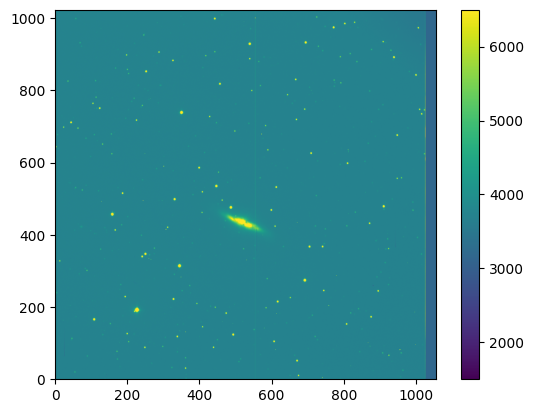

In [ ]:
plt.imshow(data, origin='lower', vmin=1500, vmax=6500)
plt.colorbar()

The location of the bias strip becomes very obvious when we plot a slice through the image:

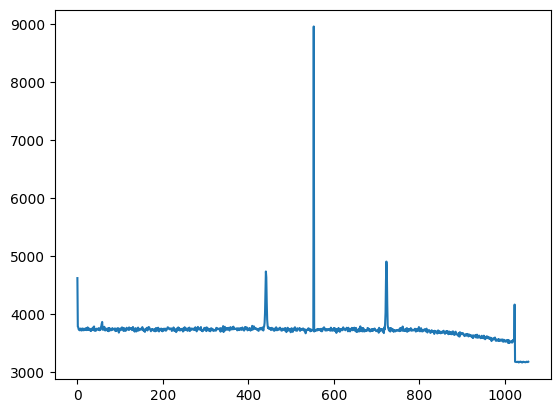

In [ ]:
plt.plot(data[1000,:])

Try plotting a few different slices through the image. Does the edge of the bias strip move depending on which slice you take?

We can zoom in on our slice to see more precisely where the bias strip is.

(2750.0, 5000.0)

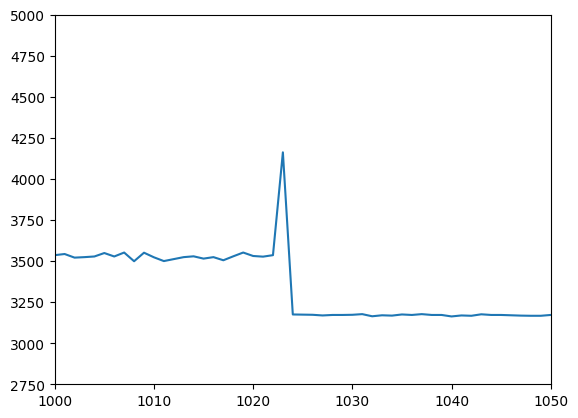

In [ ]:
plt.plot(data[1000,:])
plt.xlim([1000,1050])
plt.ylim([2750,5000])

Carefully inspect the plot to identify where the data end and the bias strip begins.

It looks like a good bias section is x = 1025 through 1054 inclusive.

We should also trim the image to remove bad values at the ends. Take a look at a few image slices to see where the data start to look bad.

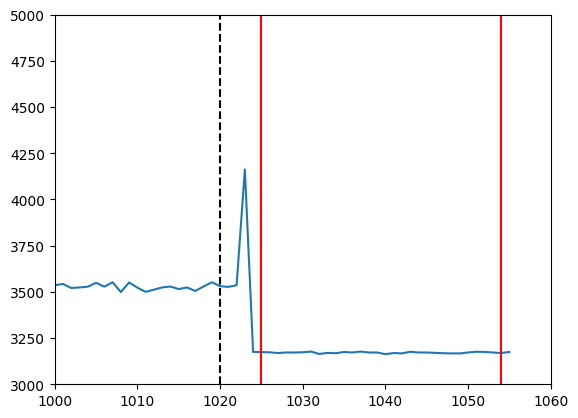

In [ ]:
# plot the data
plt.plot(data[1000,:])
plt.xlim([1000,1060])
plt.ylim([3000,5000])

# visualize our threshold values
# the end of the data
plt.plot([1020,1020], [3000,9000], color='black', linestyle='dashed')
# the bias strip
plt.plot([1025,1025], [3000,9000], color='red')
plt.plot([1054,1054], [3000,5000], color='red')

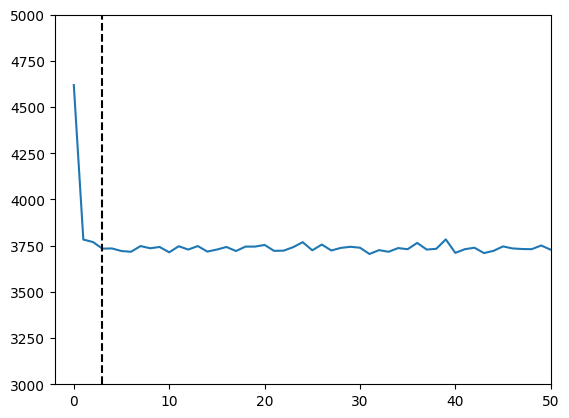

In [ ]:
# plot the data
plt.plot(data[1000,:])
plt.xlim([-2,50])
plt.ylim([3000,5000])

# visualize our threshold values
# the end of the data
plt.plot([3,3], [3000,9000], color='black', linestyle='dashed')

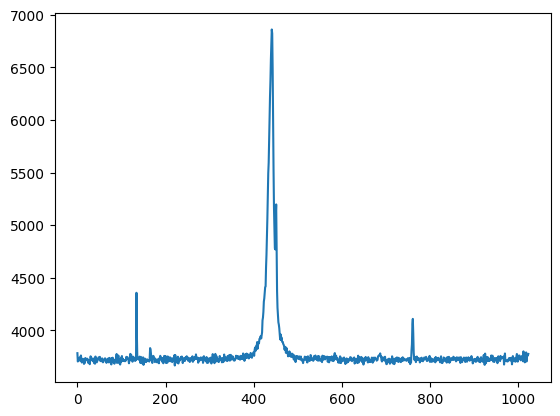

In [ ]:
# aaand a slice in y

# plot the data
plt.plot(data[:,500])


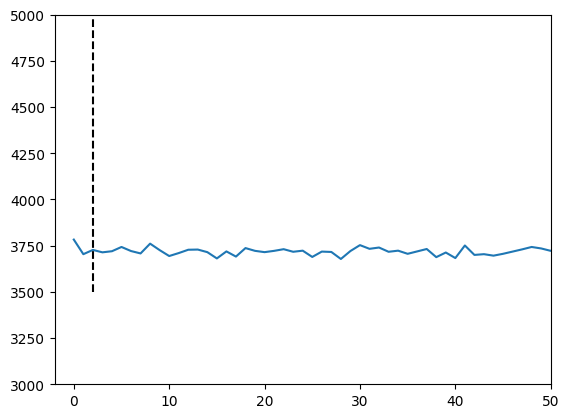

In [ ]:
# y limits -- zooming in on the lower end

# plot the data
plt.plot(data[:,500])
plt.xlim([-2,50])
plt.ylim([3000,5000])

plt.plot([2,2], [3500,5000], color='black', linestyle='dashed')

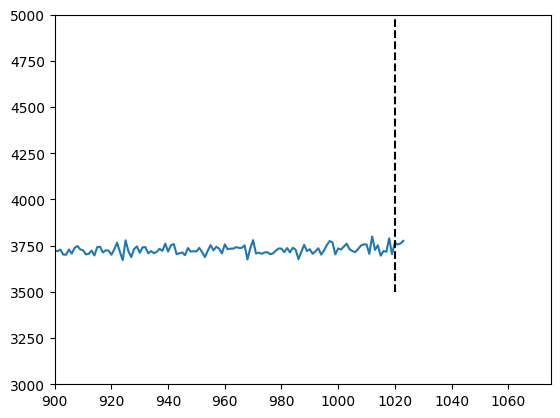

In [ ]:
# y limits -- zooming in on the upper end

# plot the data
plt.plot(data[:,500])
plt.xlim([900,1075])
plt.ylim([3000,5000])

plt.plot([1020,1020], [3500,5000], color='black', linestyle='dashed')

To keep things straight, and in case we’d like to change them later, let’s define the following limits for trimming and for bias extraction, in image coordinates:

In [ ]:
x1 = 3     # first good pixel in x after trim
x2 = 1020  # last pixel to include in x after trim

y1 = 2     # first good pixel in y after trim
y2 = 1020  # last pixel to include in y after trim

bx1 = 1025 # first pixel of bias section
bx2 = 1054 # last pixel of bias section

Now we extract the portion of the image that we want to keep:

In [ ]:
ndata = data[y1:y2,x1:x2] #grabs the good section, but still need to subtract bias

Now we want to subtract the bias from each row of the data. You can do this with a ```for``` loop that does the computation line-by-line.

In [ ]:
ndata_rm_bias = np.zeros(ndata.shape)

for y in range(y1,y2):
    ndata_rm_bias[y-y1,:] = ndata[y-y1,:] - np.median(data[y,bx1:bx2])

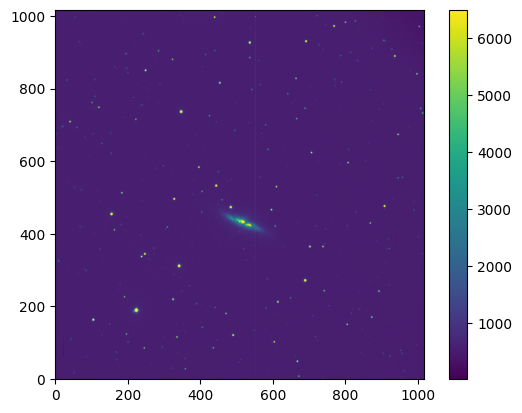

In [ ]:
plt.imshow(ndata_rm_bias, origin='lower', vmax=6500)
plt.colorbar()

As with many things, there is more than one way to approach this coding challenge.

For example, loops can be slooooow and painful for large data. Fortunately, python can do this same arithmetic much faster in vectorized form. All it takes is a little array manipulation.

In [ ]:
# find the single value of the bias for every row in the image
row_bias = np.median(data[y1:y2,bx1:bx2], axis=1)
# reshape the array to be the same size as the image
bias = np.tile(row_bias[:,np.newaxis], (1, ndata.shape[1]))

# subtract the new array from the image
ndata_no_bias = ndata - bias

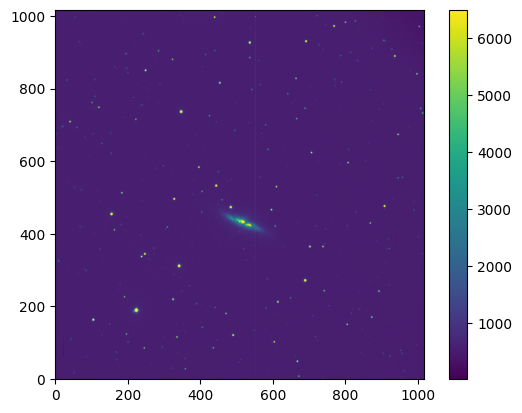

In [ ]:
plt.imshow(ndata_no_bias, origin='lower', vmax=6500)
plt.colorbar()

The plots look pretty similar - a good first test that we get the same answer with both approaches.

A better test is to take the difference between the two bias-subtracted images. If each method truly accomplishes the same thing, then we should find zeros everywhere.

In [ ]:
test = ndata_rm_bias - ndata_no_bias
np.nonzero(test) #returns a list with the indices of non-zero elements

(array([], dtype=int64), array([], dtype=int64))

And if we plot the difference image, the value should be zero everywhere. If you see a non-zero value, something went wrong.

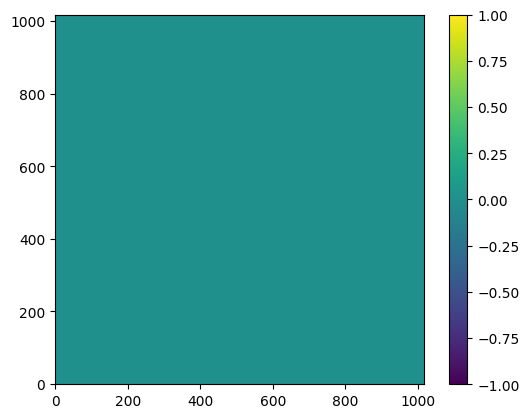

In [ ]:
plt.imshow(test, origin='lower', vmin=-1, vmax=1)
plt.colorbar()

And finally, we can compare the two arrays to check that they have the same shape and that every element is equal using `np.array_equal()`.

In [ ]:
np.array_equal(ndata_rm_bias,ndata_no_bias)

True

### So should I use the bias strip or a separate bias frame?

Not all imagers have a bias strip on the side of the detector. In that case, you have no choice but to use a separate bias frame.

Think about what both approaches are doing. Are you taking a median of several values in both cases? Does one provide a better measure of the bias as a function of time? Does one do a better job measuring variations in the bias as a function of position?

For the McDonald data, you have a choice. Try it both ways. State which bias subtraction method you prefer and why.

# Dark Current

The dark current is a signal from the environment that builds up over time and varies with temperature. Dark frames are taken when the shutter is closed and no light is falling on the detector. The exposure time of the dark frames should be the same as the science images (why?).

To calibrate the dark current, take several frames with the same exposure time as your science images.
The procedure for processing darks is similar to making a master bias image. Read in the data and take the median.

In [ ]:
darks = glob.glob('/content/drive/MyDrive/my_ASTR229_data/darks/*.fits')
darks

['/content/drive/MyDrive/my_ASTR229_data/darks/obj0058.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0059.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0057.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0054.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0055.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0056.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0060.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0061.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0063.fits',
 '/content/drive/MyDrive/my_ASTR229_data/darks/obj0062.fits']

In [ ]:
darks_frms = [fits.getdata(x) for x in darks]
mean_dark = np.mean(darks_frms, axis=0)
median_dark = np.median(darks_frms, axis=0)
stddev_dark = np.std(darks_frms, axis=0)
del darks_frms

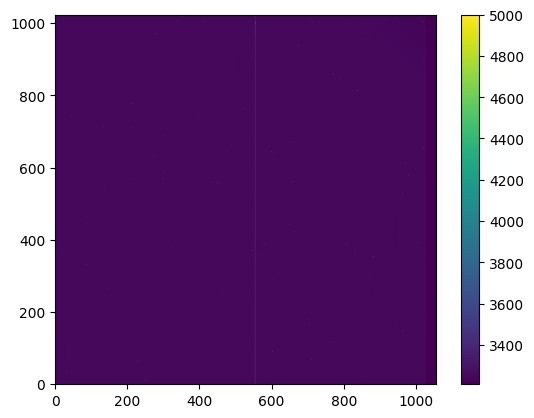

In [ ]:
plt.imshow(mean_dark, origin='lower', vmax=5000)
plt.colorbar()

In [ ]:
np.median(mean_dark)

np.float64(3248.3)

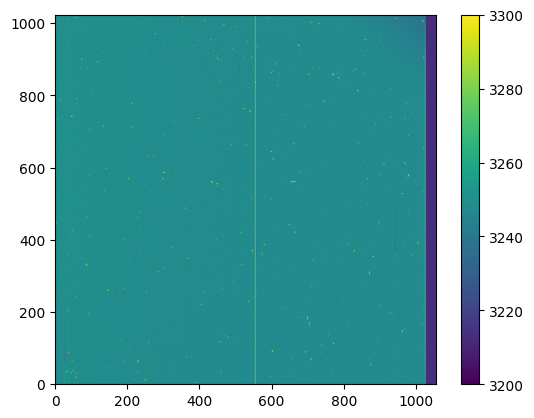

In [ ]:
plt.imshow(mean_dark, origin='lower', vmin=3200, vmax=3300)
plt.colorbar()

Notice that the median value of this master dark frame is _very_ similar to the bias level.

In [ ]:
np.median(mean_bias)

np.float64(3198.409090909091)

Even better, subtract the bias from the dark frame to see the magnitude of the dark current.

In [ ]:
diff = median_dark - median_bias
np.nanmedian(diff)

np.float64(45.0)

The CCD on the McDonald 30" is cryocooled which significantly decreases the dark current. Because the dark current is so low for this cold detector, we usually skip this step for imaging at McDonald.

When the dark current is signficant, this is subtracted from the science frame. **Be sure all your dark frames have the same exposure time as each other and your science data!**

Question for you: if you subtract the dark current using a dark frame, do you also need to subtract the bias?

# Flat field correction

Pixels have an uneven response. Even for the same input signal, different pixels will record different counts. To quantify this, we take an image of a uniformly illuminated surface. This can be either a screen in the dome illuminated with a lamp or sometimes the twilight sky. If the detector response was perfect, every pixel would have *exactly* the same number of counts. In reality, this will not be the case. A flat field allows us to correct for these pixel-to-pixel variations.

The flatfield filenames should be self-explanatory. For example, ‘V_0000.fits’ was the first flat image taken in the V filter, etc. Don't forget to trim the flatfield frames so they are the same size as your science image!

In [ ]:
Vflat = fits.open('/content/drive/MyDrive/my_ASTR229_data/flats/V_0000.fits')[0].data

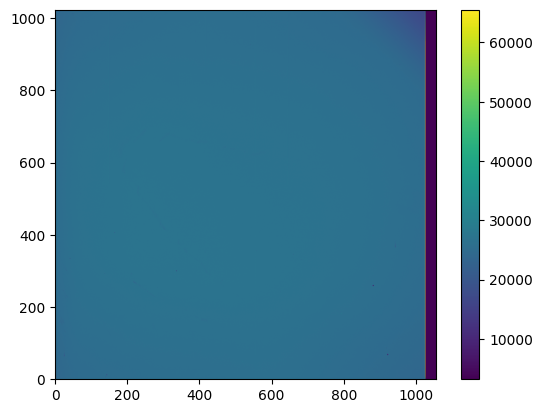

In [ ]:
plt.imshow(Vflat, origin='lower')
plt.colorbar()

Like all other types of exposures, we never take just one flatfield. After checking to make sure each exposure looks good, read in all the flats and combine them to a master flat image for each band.

When would an exposure not look good? Look for significant defects in the image frame (this can happen if someone walks into the dome while you are integrating...) and counts that are very different from the other flat field frames.

In [ ]:
Vflats = glob.glob('/content/drive/MyDrive/my_ASTR229_data/flats/V*.fits')
Vflats

['/content/drive/MyDrive/my_ASTR229_data/flats/V_0000.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0001.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0002.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0003.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0004.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0005.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0006.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0007.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0008.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0009.fits',
 '/content/drive/MyDrive/my_ASTR229_data/flats/V_0010.fits']

In [ ]:
Vflat_timestream = [fits.getdata(x)for x in Vflats]
mean_Vflat = np.mean(Vflat_timestream, axis=0)
median_Vflat = np.median(Vflat_timestream, axis=0)
del Vflat_timestream

This flatfield image still includes the bias signal so we subtract that from the flat field.

In [ ]:
bias_subtracted_Vflat = median_Vflat - median_bias

Next, we want to normalize the flat so its average value is ~1. This quantifies the pixel response. If the pixel is working perfectly, we would get 100\% of the signal - no more, no less. Most pixels will be close to this but a typical pixel will have a value a little below or a little above 1. What value would you expect for a dead pixel (a dead pixel no longer responds at all to incoming light)?

Normalizing the flatfield image allows us to divide the science image by the flatfield image without reducing the total number of counts in the science image.

To normalize the flatfield image, divide the flat by its mean so that the average value of the flat is ~1 everywhere.

In [ ]:
Vflat_mean = np.mean(bias_subtracted_Vflat)# wait - didn't we already take the mean? Why is this mean different?
normalized_mean_Vflat = bias_subtracted_Vflat / Vflat_mean

In [ ]:
np.mean(normalized_mean_Vflat)

np.float64(1.0000000000000004)

The image of the combined flatfield should look pretty smooth - i.e. flat.

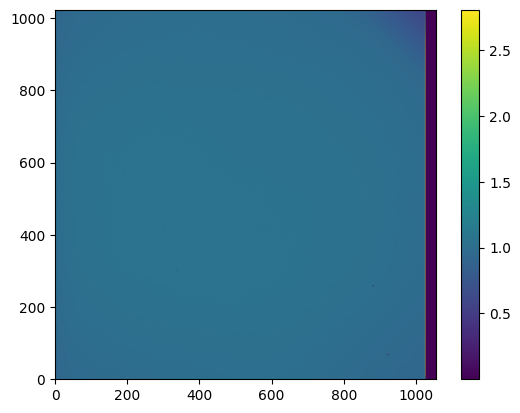

In [ ]:
plt.imshow(normalized_mean_Vflat, origin='lower')
plt.colorbar()

However, if we change the scaling, we can see some of the artifacts that the flatfield corrects.

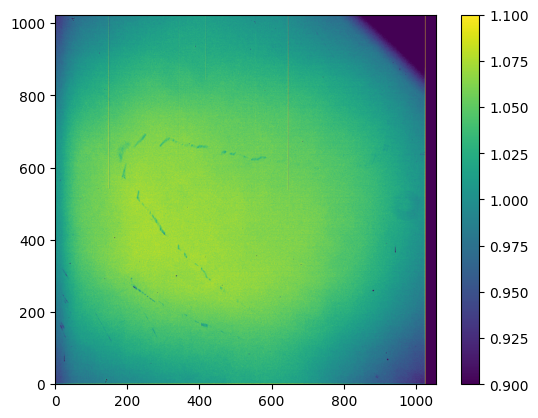

In [ ]:
plt.imshow(normalized_mean_Vflat, origin='lower', vmin=0.9, vmax=1.1)
plt.colorbar()

In [ ]:
trimmed_Vflat = normalized_mean_Vflat[y1:y2,x1:x2]

To correct for uneven pixel respone, divide the image by the flat field.

In [ ]:
ndata_ff = ndata_no_bias / trimmed_Vflat

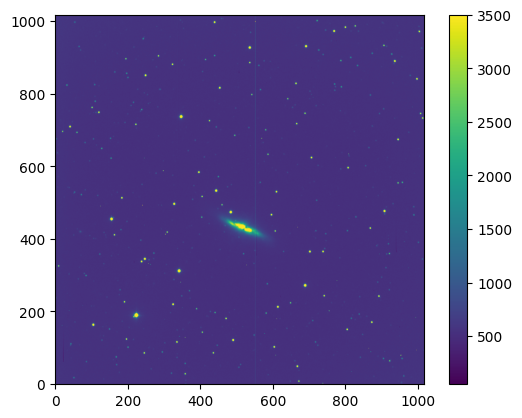

In [ ]:
plt.imshow(ndata_ff, origin='lower', vmin=50, vmax=3500)
plt.colorbar()

# Order of operations

We've just gone through the key first steps of data reduction - correcting for the bias, dark current, and flat fieldning.

The order of operations matters! We've done this in a specific order for a reason. You always want to do the additive steps first, then the multiplicative steps. Why? Because $(A-B)/F \ne A/F - B$!

# update the header and save the processed data

You can add information to the image header to keep track of what processing you have done to the data. For example, you might like to update the header to store the trim section and bias section you used.

You can do this by adding a new keyword to the header. Assign it a string value that records the key details about your image processing.

In [ ]:
nheader = header # copy the original header
nheader['BIASSEC'] = "["+str(bx1)+":"+str(bx2)+","+str(y1)+":"+str(y2)+"]"
nheader['TRIMSEC'] = "["+str(x1)+":"+str(x2)+","+str(y1)+":"+str(y2)+"]"

Note the formatting! Remember,if you just put quotes around the expression used to extract the subarray, eg
nheader['TRIMSEC'] = "[x1:x2,y1:y2]" you will end up with *exactly* that statement in the header.

Check that the new information was added correctly by printing the header.

In [ ]:
nheader

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1056 / Axis length                                    
NAXIS2  =                 1024 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
BZERO   =           3.276800E4 /                                                
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
DATE    = '2024-02-15T05:49:33' / Date FITS file was generated                  
IRAF-TLM= '2024-02-15T05:48:40' / Time of last modification                     
OBJECT  = 'M82     '           / Name of the object observed                    
OBSERVAT= 'MCDONALD         

Finally, save the processed array to a new file.

As always, pick a meaningful filename - ideally that tells you someting about the processing you've already done to the data.

I usually organize my data so that the raw images are in a different folder than my processed images. You may also wish to have separate folders from ```raw``` and ```reduced``` data.

In [ ]:
fits.writeto("/content/drive/MyDrive/my_ASTR229_data/reduced/m82_V_ff.fits", ndata_ff, nheader, overwrite=True)